In [1]:
%matplotlib widget
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import constants
import pandas as pd

In [2]:
def mktable(PCtoPG, PGtoPE, PEtoPC):
    data = pd.DataFrame(0, index=['PC', 'PG', 'PE'], columns=['PC', 'PG', 'PE'])
    data.loc['PC','PG'] = PCtoPG
    data.loc['PE','PC'] = PEtoPC
    data.loc['PG','PE'] = PGtoPE

    data.loc['PG','PC'] = -data.loc['PC','PG']
    data.loc['PC','PE'] = -data.loc['PE','PC']
    data.loc['PE','PG'] = -data.loc['PG','PE']
    
    return data

In [3]:
def logSpace(xmin=-9, xmax=0, N=1000):
    grid_x = np.logspace(xmin, xmax, N)

    xPG, xPE = np.meshgrid(grid_x, grid_x) #titration grid

    xPC =  np.full((N, N), 1.0) - (xPG + xPE) #PC+PG+PE=1
    mask = xPC<0
    xPG=np.where(~mask, xPG, np.nan)
    xPE=np.where(~mask, xPE, np.nan)
    
    return xPC, xPG, xPE

In [4]:
def linSpace(xmin=0, xmax=1, N=1000):
    grid_x = np.linspace(xmin, xmax, N)

    xPG, xPE = np.meshgrid(grid_x, grid_x) #titration grid

    xPC =  np.full((N, N), 1.0) - (xPG + xPE) #PC+PG+PE=1
    mask = xPC<0
    xPG=np.where(~mask, xPG, np.nan)
    xPE=np.where(~mask, xPE, np.nan)
    
    return xPC, xPG, xPE

In [5]:
def genLogProb(E5, WT, RT):
    #Boltzmann weights
    KCG5  = np.exp(-E5.loc['PC','PG'] / RT)
    KCGWT = np.exp(-WT.loc['PC','PG'] / RT)
    KCE5  = np.exp(-E5.loc['PC','PE']/ RT)
    KCEWT = np.exp(-WT.loc['PC','PE'] / RT)

    data = (xPC + KCG5 * xPG + KCE5 * xPE) / (xPC + KCGWT * xPG + KCEWT * xPE)
    data = np.log(data)
    #data=np.where(mask, data, np.nan)
    
    return data

In [6]:
##Old numbers
#DG_PG_5  = -7
#DG_PG_WT = -11
#DG_PE_5  = -2
#DG_PE_WT = -9


#Constants
temperature = 303.15 #Kelvin
RT = temperature*constants.R/(1000*constants.calorie) #kcal/mol

lw=3
conformationCMAP = 'RdBu'
#colormap={'PC':'cornflowerblue', 'PG':'goldenrod', 'PE':'seagreen', 'WT':'red', 'E5':'black'}
#colormap={'PC':'lightsteelblue', 'PG':'khaki', 'PE':'lightgreen', 'WT':'red', 'E5':'black'}
colormap={'PC':'#EF8354', 'PG':'#3D3737', 'PE':'#613DC1', 'WT':'#D14646', 'E5':'#53A2BE'}

# Calculate and plot conformation probabilities given lipid binding

#All data:
#Using a PG reference
WT_bin = mktable(PCtoPG=-7, PGtoPE=2, PEtoPC= 7-2)
E5_bin = mktable(PCtoPG=-4, PGtoPE=6, PEtoPC= 4-6)
WT_ter = mktable(PCtoPG=-6, PGtoPE=2, PEtoPC= 6-2)
E5_ter = mktable(PCtoPG=-3, PGtoPE=6, PEtoPC= 3-6)

In [7]:
#All data:
#Using a PE reference
WT_bin = mktable(PCtoPG=-6-2, PGtoPE=2, PEtoPC= 6)
E5_bin = mktable(PCtoPG=-6-4, PGtoPE=6, PEtoPC= 4)
WT_ter = mktable(PCtoPG=-4-2, PGtoPE=2, PEtoPC= 4)
E5_ter = mktable(PCtoPG=-6-2, PGtoPE=6, PEtoPC= 2)

#All data:
#Using a PC reference
WT_bin = mktable(PCtoPG=-7, PGtoPE=-6+7, PEtoPC= 6)
E5_bin = mktable(PCtoPG=-4, PGtoPE=-4+4, PEtoPC= 4)
WT_ter = mktable(PCtoPG=-6, PGtoPE=-4+6, PEtoPC= 4)
E5_ter = mktable(PCtoPG=-3, PGtoPE=-2+3, PEtoPC= 2)

In [309]:
def addArrow(x, y, ax, direction, log):
    headSize = 70
    lineSize = 70
    lineWidth = 3
    if log==True:
        if direction in ['up', 'down']:
            xoffset = 1.001
            yoffset = 0.7
        else:
            xoffset = 0.7
            yoffset = 1.001
        
        xup = x*xoffset
        xdown = x/xoffset
        
        
        yup = y*yoffset
        ydown = y/yoffset
    else:
        if direction in ['up', 'down']:
            xoffset = 0 
            yoffset = 0.02
        else:
            xoffset = 0.02
            yoffset = 0
        
        xup = x-xoffset
        xdown = x+xoffset
        
        
        yup = y-yoffset
        ydown = y+yoffset
        
        
    if direction=='up':
        ax.scatter(x, y, marker=mpl.markers.CARETUP, color='w', s=headSize, linewidths=0)
        ax.scatter(xup, yup, marker=mpl.markers.TICKDOWN, color='w', s=lineSize, linewidths=lineWidth)
    elif direction=='down':
        ax.scatter(x, y, marker=mpl.markers.CARETDOWN, color='w', s=headSize, linewidths=0)
        ax.scatter(xdown, ydown, marker=mpl.markers.TICKUP, color='w', s=lineSize, linewidths=lineWidth)
    elif direction=='left':
        ax.scatter(x, y, marker=mpl.markers.CARETLEFT, color='w', s=headSize, linewidths=0)
        ax.scatter(xdown, ydown, marker=mpl.markers.TICKRIGHT, color='w', s=lineSize, linewidths=lineWidth)
    elif direction=='right':
        ax.scatter(x, y, marker=mpl.markers.CARETRIGHT, color='w', s=headSize, linewidths=0)
        ax.scatter(xup, yup, marker=mpl.markers.TICKLEFT, color='w', s=lineSize, linewidths=lineWidth)
    else:
        print(f"ERROR: direction {direction} not recognized")
        raise

In [406]:
def makeContourf(xPG, xPE, data, xmin=1e-9, xmax=1, log=True, cmap='jet', vmin=-8, vmax=8):
    %matplotlib widget
    
    fig, ax = plt.subplots() 

    step=0.1
    levels = np.arange(-4, 4+step, step)

    cf = ax.contourf(xPG, xPE, data, levels=levels, cmap=cmap)
    
    ax.set_xlabel(r"$x_{PG}$")
    ax.set_ylabel(r"$x_{PE}$")
    #ax.title.set_text("Relative log-probability of ELIC5 conformation")
    #ax.legend(bbox_to_anchor=(1.45,0.5))
    
    if log:
        ax.set_xscale("log")
        ax.set_yscale("log") 
        arrowWidth = 5
        arrowLength = 0.1
    else:
        arrowWidth = 5
        arrowLength = 0.2

    
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([xmin,xmax])

    
    addArrow(0.25, 0.25, ax, 'up', log)
    addArrow(0.25, xmin, ax, 'down', log)
    addArrow(1/60, xmin, ax, 'down', log)
    addArrow(xmin, 1/60, ax, 'left', log)
    
    pos = ax.get_position()
    
    cb = fig.colorbar(cf, ax=ax, ticks=np.arange(vmin, vmax+1, 2))
    #cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar
    for t in cb.ax.get_yticklabels():
        t.set_horizontalalignment('right')   
        t.set_x(4)
    
    plt.xticks([1E-6, 1E-3, 1])
    plt.yticks([1E-6, 1E-3, 1])
    
    fig.set_size_inches(2.5, 2)
    plt.subplots_adjust(bottom=0.25, left=0.25)
    ax.set_aspect('equal')
    return fig, ax

In [415]:
font = {'size'   : 10}
mpl.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


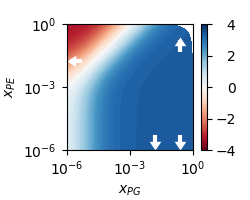

In [416]:
xPC, xPG, xPE = logSpace(-6, 0, 1000) #e^-9 to e^0, 1000 steps
data = genLogProb(E5_ter, WT_ter, RT)
fig, ax = makeContourf(xPG, xPE, data, xmin=1e-6, log=True, cmap=conformationCMAP, vmin=-4, vmax=4)
plt.savefig('logloglog_pE5.png', dpi=600, bbox_inches='tight')

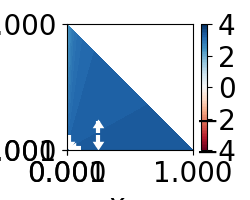

In [465]:
xPC, xPG, xPE = linSpace(0, 1, 1000) #e^-9 to e^0, 1000 steps
data = genLogProb(E5_ter, WT_ter, RT)
fig, ax = makeContourf(xPG, xPE, data, xmin=1e-6, log=False, cmap=conformationCMAP, vmin=-4, vmax=4)
plt.savefig('log_pE5.png', dpi=600)

/tmp/ipykernel_277597/2795724906.py:4: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(xPG, xPE, data)
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


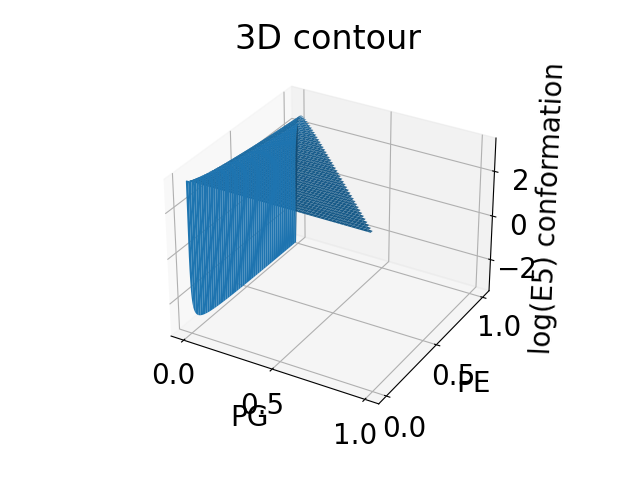

In [466]:
%matplotlib widget
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(xPG, xPE, data)
ax.set_xlabel('PG')
ax.set_ylabel('PE')
ax.set_zlabel('log(E5) conformation')

ax.set_title('3D contour')
plt.show()


# Binding in a Ternary Mixture (implementation of derivation posted Sunday, April 3, 2022)

In [467]:
def getRelProb(alpha, beta, xa, xb, stateTable, RT):
    with np.errstate(divide='ignore'):
        prob = (xa/xb) * np.exp(-stateTable.loc[beta, alpha]/RT)

    return prob

In [468]:
def getpAa(alpha, beta, gamma, xa, xb, xg, stateTable, RT):
    pA0a = 0
    pAba = getRelProb(beta, alpha, xb, xa, stateTable, RT)
    pAga = getRelProb(gamma, alpha, xg, xa, stateTable, RT)

    pAa = 1/(1+pAba+pAga+pA0a)
    
    return pAa

In [469]:
#This is the same as pAa when pA0a is 0
def getfAa(alpha, beta, gamma, xa, xb, xg, stateTable, RT):
    pAa = getpAa(alpha, beta, gamma, xa, xb, xg, stateTable, RT)
    pAb = getpAa(beta, alpha, gamma, xb, xa, xg, stateTable, RT)
    pAg = getpAa(gamma, beta, alpha, xg, xb, xa, stateTable, RT)
    
    fAa = pAa/(pAa+pAb+pAg)
    
    return fAa

In [470]:
#xPG = np.linspace(0, 1, 1000)
xPG = np.logspace(-6, 0, 100)

In [471]:
font = {'size'   : 20}
mpl.rc('font', **font)

/tmp/ipykernel_277597/2090115246.py:3: RuntimeWarning: invalid value encountered in true_divide
  prob = (xa/xb) * np.exp(-stateTable.loc[beta, alpha]/RT)


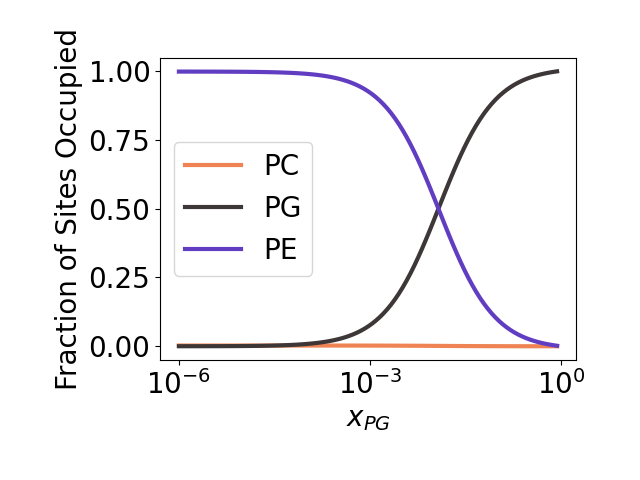

In [472]:
xPX = 1-xPG
xPC = xPX*2/3
xPE = xPX/3
%matplotlib widget

#Binary mixture numbers currently make no appreciable difference
#fPC = getfAa('PC', 'PG', 'PE', xPC,xPG,xPE, WT_bin, RT)
#fPG = getfAa('PG', 'PC', 'PE', xPG,xPC,xPE, WT_bin, RT)
#fPE = getfAa('PE', 'PG', 'PC', xPE,xPG,xPC, WT_bin, RT)

#plt.plot(xPG,fPC, label='fPC_bin')
#plt.plot(xPG,fPG, label='fPG_bin')
#lt.plot(xPG,fPE, label='fPE_bin')

fPC = getfAa('PC', 'PG', 'PE', xPC,xPG,xPE, WT_ter, RT)
fPG = getfAa('PG', 'PC', 'PE', xPG,xPC,xPE, WT_ter, RT)
fPE = getfAa('PE', 'PG', 'PC', xPE,xPG,xPC, WT_ter, RT)

plt.plot(xPG,fPC, label='PC', color=colormap['PC'], linewidth=lw)
plt.plot(xPG,fPG, label='PG', color=colormap['PG'], linewidth=lw)
plt.plot(xPG,fPE, label='PE', color=colormap['PE'], linewidth=lw)

plt.xlabel(r'$x_{PG}$')
plt.ylabel('Fraction of Sites Occupied')
#plt.title('Wild Type PG Titration')

plt.legend(loc='center left')
plt.xscale('log')
fig.set_size_inches(2.5, 2)
plt.subplots_adjust(bottom=0.25, left=0.25)
plt.xticks([1E-6, 1E-3, 1])
plt.savefig('WT_PG_Titration_Ternary.png', dpi=600)

/tmp/ipykernel_277597/2090115246.py:3: RuntimeWarning: invalid value encountered in true_divide
  prob = (xa/xb) * np.exp(-stateTable.loc[beta, alpha]/RT)


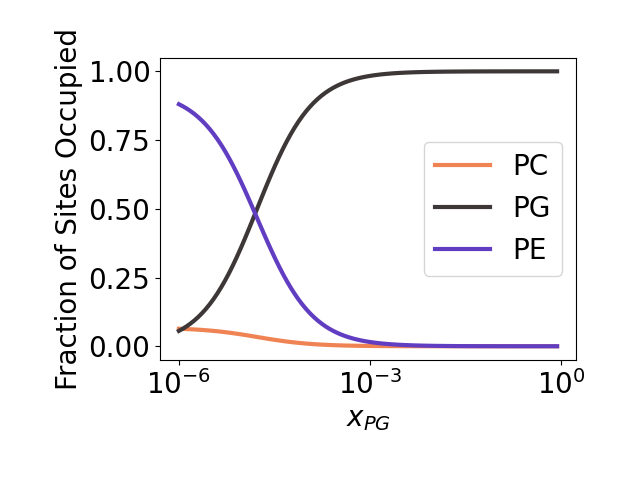

In [473]:
xPX = 1-xPG
xPC = xPX*2/3
xPE = xPX/3

fPC = getfAa('PC', 'PG', 'PE', xPC,xPG,xPE, E5_ter, RT)
fPG = getfAa('PG', 'PC', 'PE', xPG,xPC,xPE, E5_ter, RT)
fPE = getfAa('PE', 'PG', 'PC', xPE,xPG,xPC, E5_ter, RT)

%matplotlib widget
plt.plot(xPG,fPC, label='PC', color=colormap['PC'], linewidth=lw)
plt.plot(xPG,fPG, label='PG', color=colormap['PG'], linewidth=lw)
plt.plot(xPG,fPE, label='PE', color=colormap['PE'], linewidth=lw)

plt.legend()

plt.xscale('log')
plt.xlabel(r'$x_{PG}$')
plt.ylabel('Fraction of Sites Occupied')
#plt.title('ELIC5 PG Titration')
fig.set_size_inches(2.5, 2)
plt.subplots_adjust(bottom=0.25, left=0.25)
plt.xticks([1E-6, 1E-3, 1])
plt.savefig('ELIC5_PG_Titration_Ternary.png', dpi=600)

/tmp/ipykernel_277597/2090115246.py:3: RuntimeWarning: invalid value encountered in true_divide
  prob = (xa/xb) * np.exp(-stateTable.loc[beta, alpha]/RT)


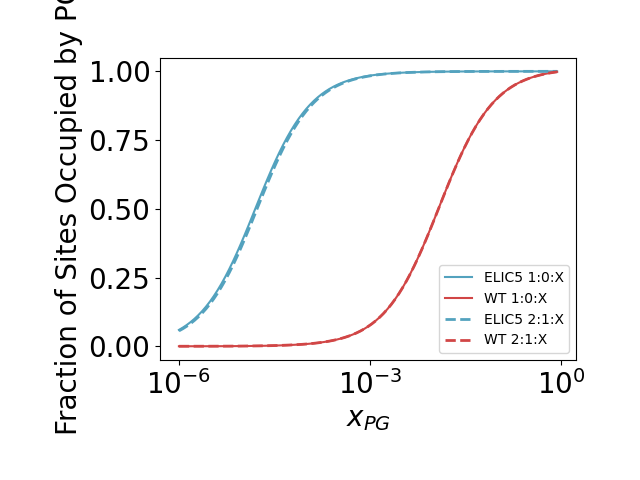

In [474]:
xPX = 1-xPG
xPC = xPX*2/3
xPE = xPX/3
#fPC = []
#for x in np.arange(len(xPG)):
    #fPC.append(getpAa('PC', 'PG', 'PE', xPC[x],xPG[x],xPE[x], WT, RT))
#Or equivalently:

WTfPG_ter = getfAa('PG', 'PC', 'PE', xPG,xPC,xPE, WT_ter, RT)
E5fPG_ter = getfAa('PG', 'PC', 'PE', xPG,xPC,xPE, E5_ter, RT)


xPC = 1-xPG
WTfPG_bin = getfAa('PG', 'PC', 'PE', xPG,xPC,xPE, WT_bin, RT)
E5fPG_bin = getfAa('PG', 'PC', 'PE', xPG,xPC,xPE, E5_bin, RT)

%matplotlib widget
plt.plot(xPG,E5fPG_bin, label='ELIC5 1:0:X', linestyle='-', color=colormap['E5'])
plt.plot(xPG,WTfPG_bin, label='WT 1:0:X', linestyle='-', color=colormap['WT'])
plt.plot(xPG,E5fPG_ter, label='ELIC5 2:1:X', linestyle='--', color=colormap['E5'], linewidth=2)
plt.plot(xPG,WTfPG_ter, label='WT 2:1:X', linestyle='--', color=colormap['WT'], linewidth=2)

#plt.xlim([10**(-9), 1])
plt.legend(loc='lower right', prop={'size':10})
plt.xscale('log')

plt.xlabel(r'$x_{PG}$')
plt.ylabel('Fraction of Sites Occupied by PG')
#plt.title('PG Titration Comparison')
#plt.xlim([1e-9, 1])

fig.set_size_inches(2.5, 2)
plt.subplots_adjust(bottom=0.25, left=0.25)
plt.xticks([1E-6, 1E-3, 1])
plt.savefig('PG_titration.png', dpi=600)

In [322]:
#Generate numbers for barchart

bar_xPC = 0.5
bar_xPG = 0.25
bar_xPE = 0.25

cols = ['fPC', 'fPG', 'fPE']
rows = pd.MultiIndex.from_tuples([('WT','2:1:1'), ('WT', '128:1'), ('E5', '2:1:1'), ('E5', '128:1')], names=['sequence', 'membrane'])
data = pd.DataFrame(columns=cols, index=rows)

data.loc[('WT','2:1:1'),'fPC'] = getpAa('PC', 'PG', 'PE', bar_xPC,bar_xPG,bar_xPE, WT_ter, RT)
data.loc[('WT','2:1:1'),'fPG'] = getpAa('PG', 'PC', 'PE', bar_xPG,bar_xPC,bar_xPE, WT_ter, RT)
data.loc[('WT','2:1:1'),'fPE'] = getpAa('PE', 'PG', 'PC', bar_xPE,bar_xPG,bar_xPC, WT_ter, RT)

data.loc[('E5','2:1:1'),'fPC'] = getpAa('PC', 'PG', 'PE', bar_xPC,bar_xPG,bar_xPE, E5_ter, RT)
data.loc[('E5','2:1:1'),'fPG'] = getpAa('PG', 'PC', 'PE', bar_xPG,bar_xPC,bar_xPE, E5_ter, RT)
data.loc[('E5','2:1:1'),'fPE'] = getpAa('PE', 'PG', 'PC', bar_xPE,bar_xPG,bar_xPC, E5_ter, RT)

bar_xPC = 128/129
bar_xPG = 1/129
bar_xPE = 0
data.loc[('WT','128:1'),'fPC'] = getpAa('PC', 'PG', 'PE', bar_xPC,bar_xPG,bar_xPE, WT_bin, RT)
data.loc[('WT','128:1'),'fPG'] = getpAa('PG', 'PC', 'PE', bar_xPG,bar_xPC,bar_xPE, WT_bin, RT)

data.loc[('E5','128:1'),'fPC'] = getpAa('PC', 'PG', 'PE', bar_xPC,bar_xPG,bar_xPE, E5_bin, RT)
data.loc[('E5','128:1'),'fPG'] = getpAa('PG', 'PC', 'PE', bar_xPG,bar_xPC,bar_xPE, E5_bin, RT)
data = data.loc[:, ['fPG', 'fPC', 'fPE']]
data.columns = ['PG', 'PC', 'PE']

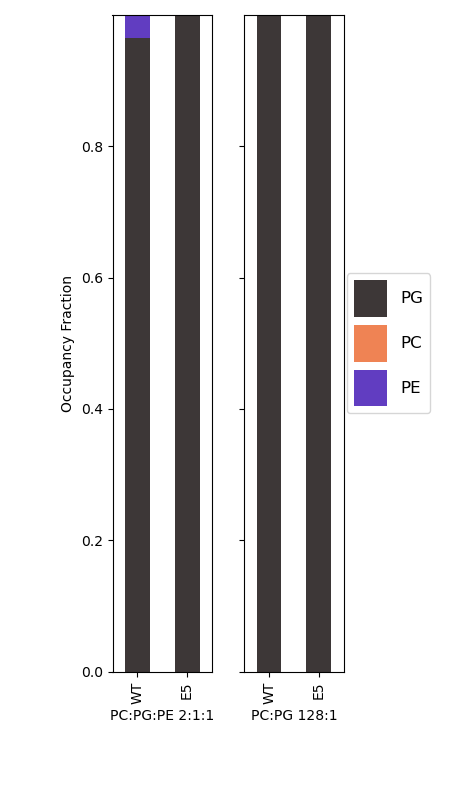

In [323]:
%matplotlib widget

fig, (ax211, ax1281) = plt.subplots(1,2, sharey=True)
data.loc[(slice(None), '2:1:1'),:].plot.bar(ax=ax211, stacked=True, color=colormap)
ax211.set_xticklabels(['WT', 'E5'])
ax211.set_xlabel('PC:PG:PE 2:1:1')

#PG, PG, PC, PC, PE, PE
hatches=['\\\\', '\\\\', '//', '//', '||', '||']
bars = ax211.patches
#for bar, hatch in zip(bars, hatches):
    #bar.set_hatch(hatch)


data.loc[(slice(None), '128:1'),:].plot.bar(ax=ax1281, stacked=True, color=colormap)
ax1281.set_xticklabels(['WT', 'E5'])
ax1281.set_xlabel('PC:PG 128:1') 

fig.set_size_inches(4.5, 7.9)

ax1281.legend(loc='center', prop={'size': 12}, handleheight=3, bbox_to_anchor=(1.45,0.5))
ax211.get_legend().remove()

#ax1281.set_position([box.x0, box.y0, box.width * 0.9, box.height])
pos = ax1281.get_position()
width = pos.x1-pos.x0
pos.x0 = 0.5      # for example 0.2, choose your value
pos.x1 = pos.x0+width
ax1281.set_position(pos)


fig.tight_layout()
#fig.suptitle('Absolute Occupancy Fraction')
ax211.set_ylabel('Occupancy Fraction')
plt.subplots_adjust(bottom=0.15, left=0.25)
#ax211.semilogy()
plt.savefig('OccupancyFraction.png', dpi=600)